<a href="https://colab.research.google.com/github/iswahyudi030303/Coba_Git/blob/main/Batik%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [4]:
sdir=r'/content/Dataset'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                           filepaths     labels
0  /content/Dataset/Sidoluhur/39.jpg  Sidoluhur
1  /content/Dataset/Sidoluhur/18.jpg  Sidoluhur
2  /content/Dataset/Sidoluhur/46.jpg  Sidoluhur
3  /content/Dataset/Sidoluhur/34.jpg  Sidoluhur
4  /content/Dataset/Sidoluhur/24.jpg  Sidoluhur
Tumbal       51
Sidoluhur    50
Sogan        50
Sidomukti    46
Name: labels, dtype: int64


In [5]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  157   test_df length:  20   valid_df length:  20


In [6]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)


test batch size:  20   test steps:  1
Found 156 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
Found 20 validated image filenames belonging to 4 classes.
['Sidoluhur', 'Sidomukti', 'Sogan', 'Tumbal']


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [7]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

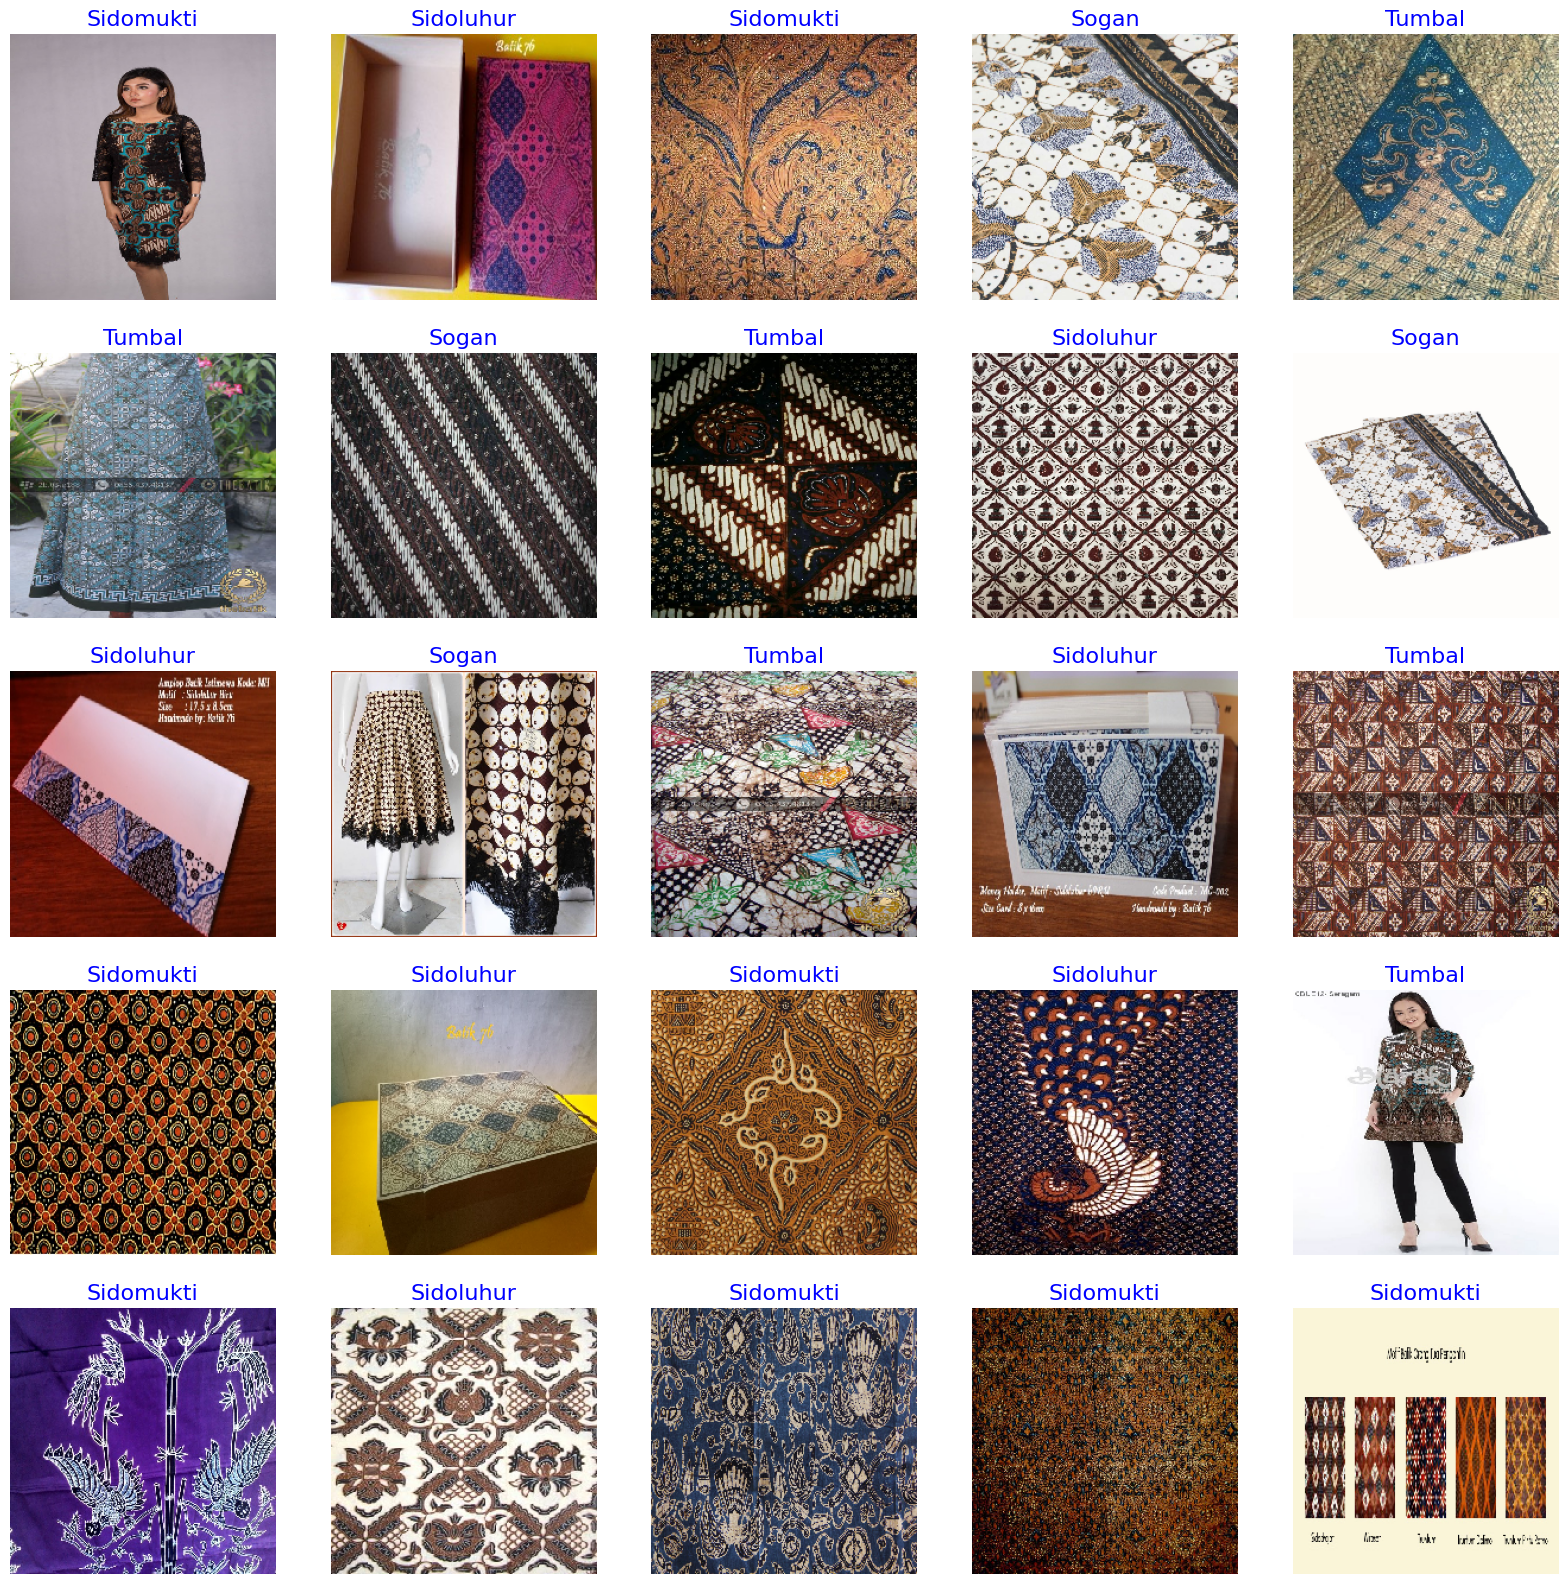

In [8]:
show_image_samples(train_gen)

In [9]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

83683744/83683744 [==============================] - 1s 0us/step


In [10]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [11]:
base_model.trainable = False

In [12]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x797479d1e710>


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 4)                 1156      
                                                        

In [1]:
epochs =100

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

NameError: name 'model' is not defined